In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("dataset/ndvi-lluvia-tmin-tmax.csv")
df.drop(columns=["departamento", "municipio", "viq", "date", "tdelta"], inplace=True)
df.ADM2_PCODE = df.ADM2_PCODE.map(lambda x: int(x[2:]))

df = df.sort_values(["ADM2_PCODE", "anio", "mes"])
df["mes_anterior"] = df.vim.shift(1)
df["anio_anterior"] = df.vim.shift(12)
df = df.fillna(df.vim.mean())
df.head()


,anio,mes,ADM2_PCODE,n_pixels,vim,lon,lat,precipitacion,tmin,tmax,mes_anterior,anio_anterior
0,2002,7,100,1.0,0.686067,-90.548878,14.435029,169.31514,16.139826,25.118555,0.714961,0.714961
315,2002,8,100,1.0,0.708233,-90.548878,14.435029,142.08778,15.987413,26.113989,0.686067,0.714961
625,2002,9,100,1.0,0.734633,-90.548878,14.435029,339.54276,16.080233,23.929758,0.708233,0.714961
940,2002,10,100,1.0,0.723900,-90.548878,14.435029,210.85938,15.551269,25.299889,0.734633,0.714961
1255,2002,11,100,1.0,0.664500,-90.548878,14.435029,120.49731,13.947153,24.349771,0.723900,0.714961


In [3]:
df_train = df[df.anio < 2020].copy().sort_values(["ADM2_PCODE", "anio", "mes"]).drop(columns="anio")
df_test = df[df.anio >= 2020].copy().sort_values(["ADM2_PCODE", "anio", "mes"]).drop(columns="anio")

ytest = df_test.vim.values
Xtest = df_test.drop(columns="vim")
ytrain = df_train.vim.values
Xtrain = df_train.drop(columns="vim")

Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape

((66144, 10), (66144,), (15120, 10), (15120,))

In [4]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
Xtrain_sc = pd.DataFrame(sc.fit_transform(Xtrain), columns=Xtrain.columns)
Xtest_sc = pd.DataFrame(sc.transform(Xtest), columns=Xtest.columns)

In [5]:
df_train_sc = Xtrain_sc.copy()
df_train_sc["vim"] = ytrain

df_test_sc = Xtest_sc.copy()
df_test_sc["vim"] = ytest

df_train_sc.head()

,mes,ADM2_PCODE,n_pixels,lon,lat,precipitacion,tmin,tmax,mes_anterior,anio_anterior,vim
0,0.545455,0.0,0.0,0.432856,0.146569,0.145635,0.527881,0.518564,0.724937,0.724937,0.686067
1,0.636364,0.0,0.0,0.432856,0.146569,0.122215,0.523973,0.552549,0.679925,0.724937,0.708233
2,0.727273,0.0,0.0,0.432856,0.146569,0.292054,0.526353,0.477977,0.714456,0.724937,0.734633
3,0.818182,0.0,0.0,0.432856,0.146569,0.181368,0.512787,0.524755,0.755582,0.724937,0.723900
4,0.909091,0.0,0.0,0.432856,0.146569,0.103645,0.471647,0.492317,0.738862,0.724937,0.664500


In [10]:
def create_dataset(df, lookback):
    X_ans = []
    y_ans = []

    for c in df.ADM2_PCODE.unique():
        X = df[df.ADM2_PCODE == c].drop(columns=["ADM2_PCODE", "vim"]).values
        y = df[df.ADM2_PCODE == c].vim.values
        for k in range(len(X) - lookback):
            feat = X[k : k + lookback]
            target = y[k : k + lookback]
            X_ans.append(feat)
            y_ans.append(target)

    return np.array(X_ans), np.array(y_ans).reshape(-1, lookback, 1)

In [28]:
LOOKBACK = 12

In [29]:
X_train, y_train = create_dataset(df_train_sc, LOOKBACK)
X_train.shape, y_train.shape

((62364, 12, 9), (62364, 12, 1))

In [30]:
X_test, y_test = create_dataset(df_test_sc, LOOKBACK)
X_test.shape, y_test.shape

((11340, 12, 9), (11340, 12, 1))

# LSTM

In [31]:
import torch 
import torch.nn as nn
from torch.optim import Adam 
from torch.utils.data import TensorDataset, DataLoader

In [32]:
torch.manual_seed(1)

In [33]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.float)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.float)

In [34]:
class VimModel(nn.Module):
    def __init__(self, hidden_size=32, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=9, hidden_size=hidden_size, batch_first=True, num_layers=num_layers)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        # x = x[:, -1, :]
        x = self.relu(x)
        return self.linear(x)

In [35]:
model = VimModel(hidden_size=32, num_layers=3)
model(X_test_tensor).shape

torch.Size([11340, 12, 1])

In [36]:
model = VimModel(hidden_size=32, num_layers=2)
opt = Adam(model.parameters(), lr=1e-3)
loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), shuffle=True, batch_size=16)
mse = nn.L1Loss()


epochs = 50

train_loss = []
test_loss = []

patience = 5
counter = 0
best = 9999
best_dict = {}

for e in range(epochs):
    model.train()
    temp = []
    cnt = 0
    for X_batch, y_batch in loader:
        model.train()
        y_pred = model(X_batch)
        loss = mse(y_batch, y_pred)
        opt.zero_grad()
        loss.backward()
        opt.step()
        temp.append(torch.mean(torch.abs(y_pred - y_batch) / y_batch).item())
        cnt += 1

        if cnt % 1_000 == 0:
            train_loss.append(np.mean(temp))
            temp = []
            model.eval()
            y_pred = model(X_test_tensor)
            test_loss.append(torch.mean(torch.abs(y_pred - y_test_tensor) / y_test_tensor).item())

            if test_loss[-1] < best:
                counter = 0
                best = test_loss[-1]
                best_dict = model.state_dict()
            else:
                counter += 1

            print(f"Epoch {e:2d}, iter {cnt:4d}, MAPE Entrenamiento {train_loss[-1]:.4f}, MAPE Evaluación {test_loss[-1]:.4f}")

    if counter >= patience: break

model.load_state_dict(best_dict)

Epoch  0, iter 1000, MAPE Entrenamiento 0.1007, MAPE Evaluación 0.0239
Epoch  0, iter 2000, MAPE Entrenamiento 0.0242, MAPE Evaluación 0.0162
Epoch  0, iter 3000, MAPE Entrenamiento 0.0183, MAPE Evaluación 0.0131
Epoch  1, iter 1000, MAPE Entrenamiento 0.0153, MAPE Evaluación 0.0118
Epoch  1, iter 2000, MAPE Entrenamiento 0.0149, MAPE Evaluación 0.0118
Epoch  1, iter 3000, MAPE Entrenamiento 0.0144, MAPE Evaluación 0.0117
Epoch  2, iter 1000, MAPE Entrenamiento 0.0141, MAPE Evaluación 0.0125
Epoch  2, iter 2000, MAPE Entrenamiento 0.0140, MAPE Evaluación 0.0116
Epoch  2, iter 3000, MAPE Entrenamiento 0.0139, MAPE Evaluación 0.0112
Epoch  3, iter 1000, MAPE Entrenamiento 0.0135, MAPE Evaluación 0.0123
Epoch  3, iter 2000, MAPE Entrenamiento 0.0132, MAPE Evaluación 0.0115
Epoch  3, iter 3000, MAPE Entrenamiento 0.0134, MAPE Evaluación 0.0111
Epoch  4, iter 1000, MAPE Entrenamiento 0.0130, MAPE Evaluación 0.0108
Epoch  4, iter 2000, MAPE Entrenamiento 0.0129, MAPE Evaluación 0.0108
Epoch 

<All keys matched successfully>

Text(0, 0.5, 'MAPE')

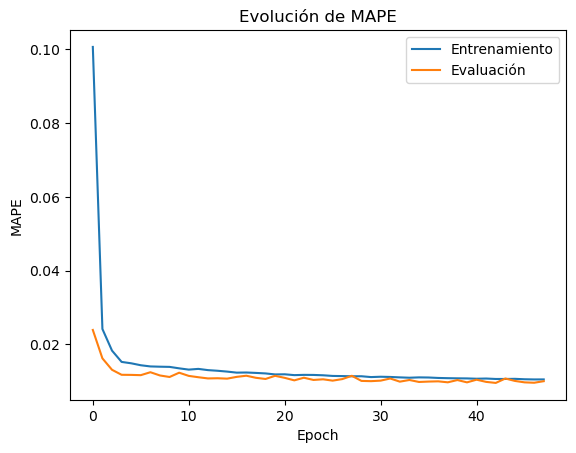

In [37]:
import matplotlib.pyplot as plt 

plt.plot(train_loss, label="Entrenamiento")
plt.plot(test_loss, label="Evaluación")
plt.legend()
plt.title("Evolución de MAPE")
plt.xlabel("Epoch")
plt.ylabel("MAPE")

In [43]:
torch.save(model.state_dict(), "best_lstm")
model.load_state_dict(torch.load("best_lstm"))

<All keys matched successfully>

In [38]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [39]:
ypred = model(X_train_tensor).detach().numpy()[:, -1, :]
ytrue = y_train[:, -1, :]

mean_absolute_percentage_error(ytrue, ypred), r2_score(ytrue, ypred)

(0.009055668193294106, 0.9943220524002753)

In [40]:
ypred = model(X_test_tensor).detach().numpy()[:, -1, :]
ytrue = y_test[:, -1, :]

mean_absolute_percentage_error(ytrue, ypred), r2_score(ytrue, ypred)

(0.008824067726963704, 0.9935797480787604)

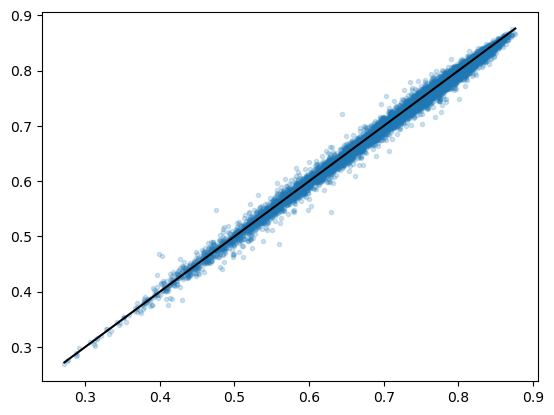

In [41]:
plt.plot(ytrue, ypred, ".", alpha=0.2)
plt.plot([ytrue.min(), ytrue.max()], [ytrue.min(), ytrue.max()], "k")

# Regresión Lineal

In [171]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(Xtrain_sc, ytrain)

LinearRegression()

In [172]:
ypred = lr.predict(Xtrain_sc)
mean_absolute_percentage_error(ytrain, ypred), r2_score(ytrain, ypred)

(0.034298425919324936, 0.9213627918443481)

In [173]:


ypred = lr.predict(Xtest_sc)
mean_absolute_percentage_error(ytest, ypred), r2_score(ytest, ypred)

(0.028971973745838236, 0.938013630203765)

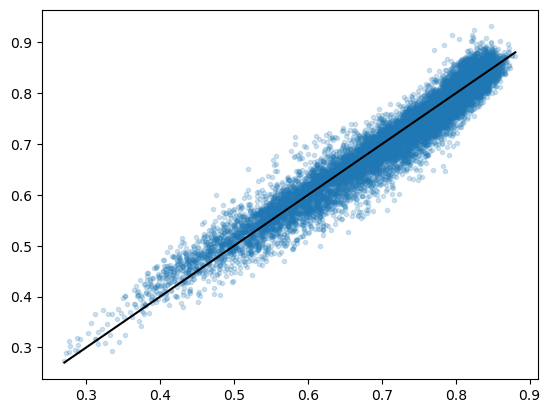

In [174]:
plt.plot(ytest, ypred, ".", alpha=0.2)
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], "k")

In [177]:
import seaborn as sns

<Axes: xlabel='imp', ylabel='var'>

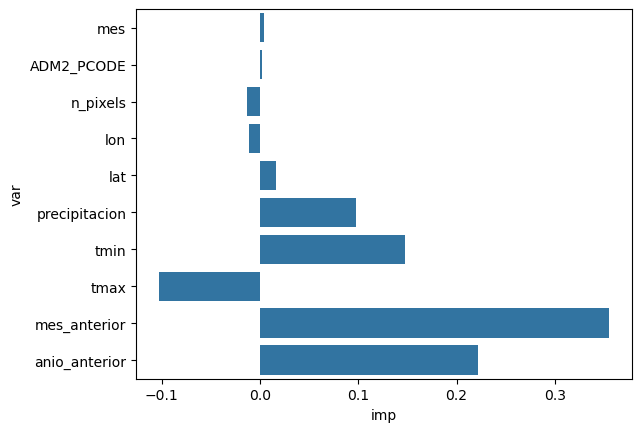

In [178]:

imp = pd.DataFrame({"var": Xtrain.columns, "imp": lr.coef_})
sns.barplot(imp, x="imp", y="var")

# LGBMRegressor

In [185]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

In [200]:
lg = LGBMRegressor(random_state = 1)
params = {
    "num_leaves": [20, 31, 50]
}
gs = GridSearchCV(lg, params, cv=5)
gs.fit(Xtrain_sc, ytrain)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2090
[LightGBM] [Info] Number of data points in the train set: 52915, number of used features: 10
[LightGBM] [Info] Start training from score 0.718671
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2093
[LightGBM] [Info] Number of data points in the train set: 52915, number of used features: 10
[LightGBM] [Info] Start training from score 0.716097
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=1),
             param_grid={'num_leaves': [12, 20, 31, 50]})

In [201]:
best_params = gs.best_params_
print(best_params)
lg = LGBMRegressor(**best_params, random_state=1)
lg.fit(Xtrain_sc, ytrain)

{'num_leaves': 50}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2097
[LightGBM] [Info] Number of data points in the train set: 66144, number of used features: 10
[LightGBM] [Info] Start training from score 0.712593


LGBMRegressor(num_leaves=50, random_state=1)

In [202]:
ypred = lg.predict(Xtrain_sc)
mean_absolute_percentage_error(ytrain, ypred), r2_score(ytrain, ypred)

(0.01417432033638468, 0.9868018344048908)

In [203]:
ypred = lg.predict(Xtest_sc)
mean_absolute_percentage_error(ytest, ypred), r2_score(ytest, ypred)

(0.013775358202848535, 0.9854710163480508)

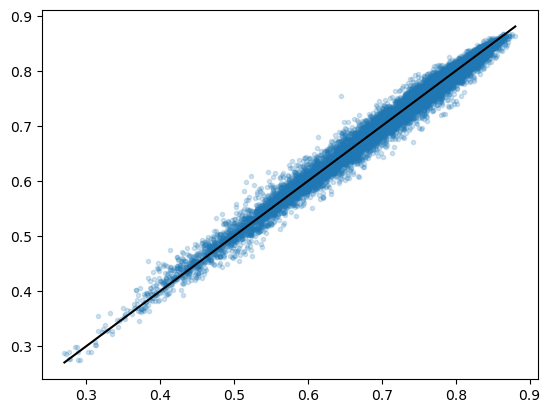

In [204]:
plt.plot(ytest, ypred, ".", alpha=0.2)
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], "k")

<Axes: xlabel='imp', ylabel='var'>

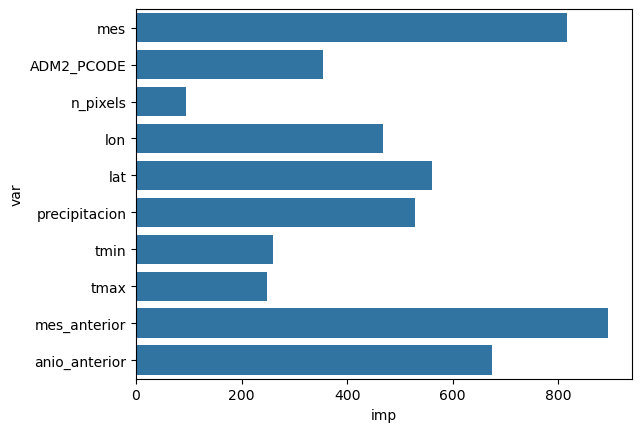

In [206]:
imp = pd.DataFrame({"var": Xtrain.columns, "imp": lg.feature_importances_})
sns.barplot(imp, x="imp", y="var")